In [ ]:
import os
import json
from tqdm import tqdm

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}


PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

In [29]:
# 증강된 이미지 및 라벨 디렉토리 설정
AUGMENTED_IMAGE_ROOT = "/data/ephemeral/home/heejin/level2-cv-semanticsegmentation-cv-18-lv3/data/train/DCM_augmented/ID002"
AUGMENTED_LABEL_ROOT = "/data/ephemeral/home/heejin/level2-cv-semanticsegmentation-cv-18-lv3/data/train/outputs_json_augmented/ID002"


In [30]:
def label2rgb(label: np.ndarray, height: int, width: int) -> np.ndarray:
    """
     클래스 별 마스크를 색상 팔레트에 따라 RGB 이미지로 변환해주는 function
    """
    image = np.zeros((height, width, 3), dtype=np.uint8)
    for i, class_mask in enumerate(label):
        color = PALETTE[i % len(PALETTE)]
        image[class_mask == 1] = color
    return image


In [31]:
def load_image_paths(directory: str):
    image_paths = {}
    for root, _, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths[f] = os.path.join(root, f)
    return image_paths

In [32]:

def display_augmented_segmentation_pair(image_name: str):

    """
        증강된 이미지와 해당 이미지의 polygon 시각화 
    """
    image_path = os.path.join(AUGMENTED_IMAGE_ROOT, image_name)
    base_name = os.path.splitext(image_name)[0]
    label_name = f"{base_name}.json"
    label_path = os.path.join(AUGMENTED_LABEL_ROOT, label_name)
    
    if not os.path.exists(image_path):
        print(f"Augmented image not found: {image_path}")
        return
    if not os.path.exists(label_path):
        print(f"Augmented label not found: {label_path}")
        return
    
    # 이미지 로드
    try:
        image = np.array(Image.open(image_path).convert('RGB'))
    except Exception as e:
        print(f"Failed to load image {image_path}: {e}")
        return
    height, width = image.shape[:2]
    mask = np.zeros((len(CLASSES), height, width), dtype=np.uint8)
    
    # 라벨 로드
    try:
        with open(label_path, "r") as f:
            annotations = json.load(f)["annotations"]
    except Exception as e:
        print(f"Failed to load label {label_path}: {e}")
        return
    
    for ann in annotations:
        class_name = ann.get("label")
        points = ann.get("points")
        if class_name not in CLASS2IND:
            print(f"Unknown class: {class_name}")
            continue
        class_idx = CLASS2IND[class_name]
        if not isinstance(points, list):
            print(f"Invalid points format for class {class_name} in {label_name}")
            continue
        try:
            polygon = np.array(points, dtype=np.int32)
            if polygon.ndim != 2 or polygon.shape[1] != 2:
                print(f"Invalid polygon shape for class {class_name} in {label_name}")
                continue
        except Exception as e:
            print(f"Error processing points for class {class_name} in {label_name}: {e}")
            continue
        cv2.fillPoly(mask[class_idx], [polygon], 1)
    
    # 마스크 색칠
    color_mask = label2rgb(mask, height, width)
    
    # 이미지와 마스크 블렌딩
    try:
        blended = cv2.addWeighted(image, 0.5, color_mask, 0.5, 0)
    except Exception as e:
        print(f"Failed to blend image and mask for {image_name}: {e}")
        return
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title("Augmented Image")
    axes[0].axis('off')
    
    axes[1].imshow(blended)
    axes[1].set_title("Augmented Segmentation")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


In [33]:
def visualization(num_samples: int = 5):
    augmented_files = [f for f in os.listdir(AUGMENTED_IMAGE_ROOT) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = augmented_files[:num_samples]
    
    print(f"Displaying {len(selected_files)} augmented segmentation pairs.")
    for image_name in selected_files:
        display_augmented_segmentation_pair(image_name)

Displaying 2 augmented segmentation pairs.


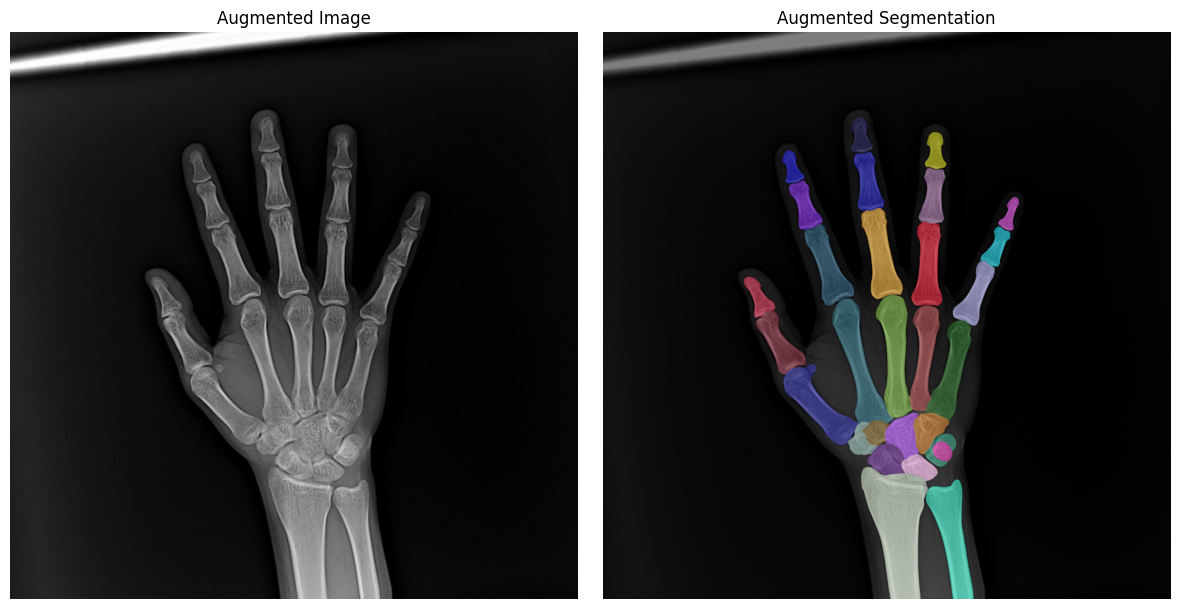

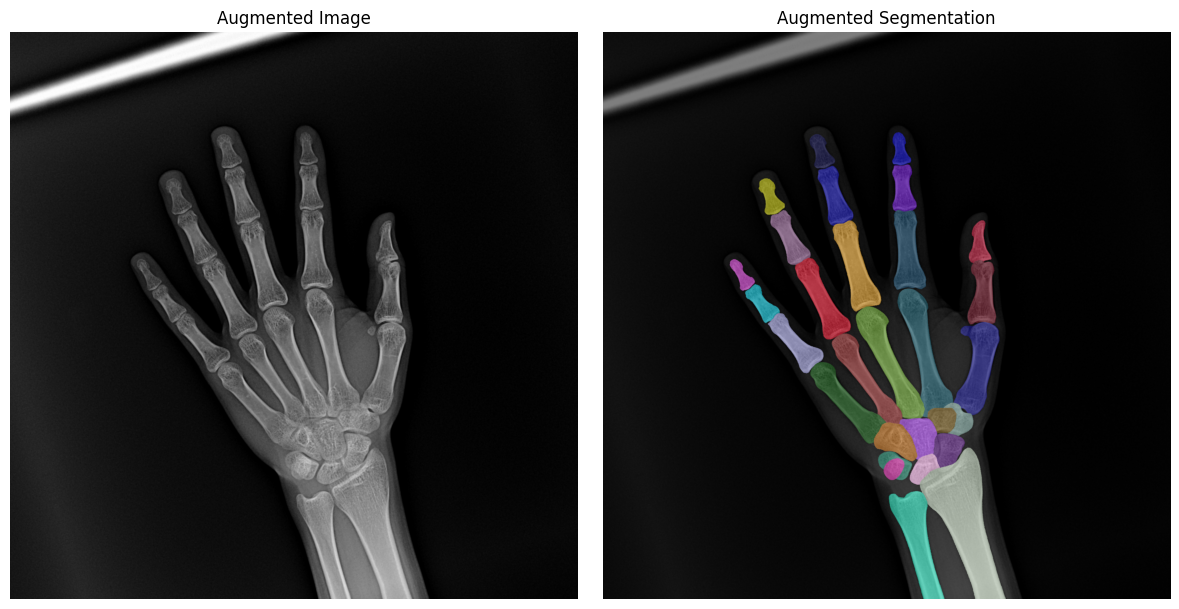

In [34]:
if __name__ == "__main__":
    visualization()
